<a href="https://colab.research.google.com/github/palaciosalondra584-dev/Inteligencia_Artificial/blob/main/Exposicion/Exposicion_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###Cargamos las librerias que vamos a usar

import numpy as np    #Para calculos matematicos avanzados
import pandas as pd   #Para manejr los datos como si fuera una hoja de calculo
import random         #Pra genrerar numeros aleatorios simples
from datetime import datetime, timedelta  # Para trabajar datos de tiempo como fecha y hora


#Generamos el conjunto de datos con 500 usuarios
def generate_realistic_fraud(
    n_users=500, #Colocamos el numero de usuaios
    tx_per_user_mean=40, #Colocamos el promedio de transacciones para cada cliente
    seed=42, #Para generar el mismo conjunto de datos, el 42 es por que es lo que siempre se utiliza cualquier otro numero funcionaria
    base_fraud_rate=0.03 #Tasa esperada del fraude que normalmente en la vida diaria esta por debajo del 1% o 2%
):
    random.seed(seed) #Por defecto, casi siempre se coloca el 42
    np.random.seed(seed) #Para que el codigo sea reproducible cada que ingreses

    rows = [] #Creamos una lista de datos vacia para añadir una por una las transacciones realizadas
    tx_id = 0 #Inicia a contar apartir del ID en cero
    base_date = datetime.now() - timedelta(days=365)  #Colocamos la fceha inicial y le restas 365 para empezar a crearla a partir de un año anterior

    tx_types = [
        'purchase', 'transfer', 'cash_withdrawal',
        'international_transfer', 'payment'
    ]   #Definimos los tipos de transacciones (compra,transferencia nacional, retiro de efectivo, transferencia internacional,pago de servicios o facturas)

    #Elegimos aleatoriamente el 5%(25 usuarios) de todos los usuarios para que sean ususarios de alto riesgo
    high_risk_users = set(random.sample(range(1, n_users+1), int(0.05*n_users)))

    #Comenzamos a generar transacciones desde 1 hasta 500 por defecto
    for u in range(1, n_users+1):
      #Definimos cuantas transacciones hara el usuario (Al menos 10 cada usuario)
        n_tx = max(10, int(np.random.poisson(tx_per_user_mean)))
        #Establecemos la hora de la primera transaccion aleatoriamente dentro de 330 dias
        last_time = base_date + timedelta(days=random.randint(0, 330))

       #Ajustamos la tasa de fraude y la multiplicamos por 4 para equilibrar la base lo mas posible a la realidad
        user_fraud_rate = base_fraud_rate * (4 if u in high_risk_users else 1)

      #Comenzamos un bucle de transacciones
        for i in range(n_tx):
      #Para hacer ir subiendo de uno en uno el contador de transacciones
            tx_id += 1

      #Calculamos el tiempo de espera haciendo que unas tarden mas y otras un poco menos
            delta_seconds = int(abs(np.random.exponential(scale=3600*12)))
      #Para sumar el tiempo de espera al momento de hacer la ultima transaccion
            this_time = last_time + timedelta(seconds=delta_seconds)
      #Generamos un monto con un minimo de $1 para las transacciones
            amount = round(max(1.0, np.random.lognormal(mean=3.3, sigma=1.1)), 2)
      #Elegimos un tipo de transaccion al hazar y guardamos el tiempo de espera, verificando si es fraude o no
            tx_type = random.choice(tx_types)
            secs_since_prev = delta_seconds
      #Coloca 0 en donde piensa que es un fraude y luego lo verifica
            is_fraud = 0

      #Gneramos la primera simulacion de ataque rapido y repetitivo (Rafaga)
      # Si se generan entre 3 y 8 transacciones seguidas en cuestion de segundos con montos altos
      #los marca como 1 que es fraude
            if random.random() < 0.015:
                burst_len = random.randint(3, 8)
                for b in range(burst_len):
                    tx_id += 1
                    rows.append({
                        'tx_id': tx_id,
                        'user_id': f'user_{u}',
                        'timestamp': (this_time + timedelta(seconds=b)).isoformat(),
                        'amount': round(amount * random.uniform(1.2, 4.5), 2),
                        'secs_since_prev': random.randint(1, 15),
                        'tx_type': "transfer",
                        'is_high_amount': 1,
                        'label': 1
                    })
                last_time = this_time
                continue

      #Generamos nuestra segunda simulacion escalonada es decir si se hacen de entre 6 a 8
      #transferencias donde el monto es 1.8 mayor mayor al anterior lo marac como 1 (fraude)
            if random.random() < 0.02:
                levels = random.randint(3, 6)
                base_amt = random.uniform(100, 500)
                for lev in range(levels):
                    tx_id += 1
                    amt = base_amt * (1.8 ** lev)
                    rows.append({
                        'tx_id': tx_id,
                        'user_id': f'user_{u}',
                        'timestamp': (this_time + timedelta(seconds=lev*20)).isoformat(),
                        'amount': round(amt, 2),
                        'secs_since_prev': 20,
                        'tx_type': "international_transfer",
                        'is_high_amount': int(amt > 3000),
                        'label': 1
                    })
                last_time = this_time
                continue

            # Generamos nuestra tercera simulacion por anomalia nocturna es decir
            #Fraudes por horario y monto si la transaccion es de la 1 a las 4 am y
            #mayor a $5000 lo coloca como fraude (1)
            if 1 <= this_time.hour <= 4 and amount > 5000:
                is_fraud = 1

            #Generamos nuestra cuarta simulacion donde se el usuario esta en lista
            #de alto riesgo es decir si cumple con una probabilidad del 10% lo marca como fraude
            if u in high_risk_users and random.random() < 0.10:
                is_fraud = 1

            #Generamos nuestra quinta y ultima simulacion donde si se cumple con la probabilidad definida
            #se marca como 1
            if random.random() < user_fraud_rate:
                is_fraud = 1

            #Guardamps las transacciones en una lista como un diccionario
            #(Identificador de transaccion,cliente,fecha y hora,monto, tiempo transcurrido
            #tipo de transaccion, si el monto supera los $3,000, y la etiqueta si es fraude o no (0 y 1)
            rows.append({
                'tx_id': tx_id,
                'user_id': f'user_{u}',
                'timestamp': this_time.isoformat(),
                'amount': amount,
                'secs_since_prev': secs_since_prev,
                'tx_type': tx_type,
                'is_high_amount': int(amount > 3000),
                'label': is_fraud
            })

      #Lo ocupamos para actualizar la hora en cada transaccion

            last_time = this_time

#Convertimos los datos generados en una tabla con pandas
    df = pd.DataFrame(rows)
#Desordenamos al azar las filas haciendolo mas realista
    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
#Muestra la tabla final
    return df

#Llama a la funcion que acabamos de realizar que lo hace mas realista
df = generate_realistic_fraud()
#Toma la tabla de datos y lo guarda en la computadora como un archivo csv
df.to_csv("base_fraude_realista.csv", index=False)
#Muestra un resumen de las primeras 5 filas y calcula la tasa de fraude promedio
df.head(), df["label"].mean()


(   tx_id   user_id                   timestamp  amount  secs_since_prev  \
 0  15281  user_329  2024-12-16T02:21:52.615911   10.78                7   
 1  22682  user_488  2025-01-27T09:33:45.615911    9.70            35473   
 2  13021  user_280  2025-01-05T18:36:10.615911   51.42            45167   
 3  19325  user_418  2025-09-17T00:36:17.615911   16.26            19398   
 4   6989  user_151  2025-08-06T20:29:52.615911   50.38           110119   
 
     tx_type  is_high_amount  label  
 0  transfer               1      1  
 1  purchase               0      0  
 2  purchase               0      0  
 3  transfer               0      0  
 4  purchase               0      0  ,
 np.float64(0.18321690688831904))

In [2]:
#Ocupamos diversas herramientas de sklearn

#Estandarizar los datos con media de 0 y desviacion estandar de 1
from sklearn.preprocessing import StandardScaler
#Pra convertir los datos de texto en numeros binarios de 0 y 1
from sklearn.preprocessing import OneHotEncoder
#Pra dividir los datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Ordemos los datos en usuario y tiempo ya que son las dos variables mas clave
df = df.sort_values(["user_id", "timestamp"])

# Para dar una matriz con numeros completos para ser mas sencilla de leer
enc = OneHotEncoder(sparse_output=False)
#Aprende el tipo de transacciones
#Y crea nuevas columnas binarias (0 y 1)
cat = enc.fit_transform(df[["tx_type"]])

# Normalizamos los valores
scaler = StandardScaler()
#Calculamos la media y la deviacion estandar
num = scaler.fit_transform(df[["amount", "secs_since_prev"]] )

#Une las variables en una matriz con todas las caracteristicas
#(numeros,tipos,y que las columnas se añaden horizontalmente)
X = np.concatenate([num, cat, df[["is_high_amount"]].values], axis=1)
#Estrae la columna label (0,1) y lo guarad en y que es lo que se intenta predecir
y = df["label"].values


In [16]:
#Definimos la longuitud de secuencia para que observe las ultimas 20 transacciones
SEQ_LEN = 20

#Creamos una secuencia para tomar entradas, salidas y la longuitud
def create_sequences(X, y, seq_len=SEQ_LEN):
#Se crean dos listas vacias para fraude y no fraude
    Xs, ys = [], []
  #Creamos un bucle que se detiene en 20 posiciones para asegurar que se hagan las
  #20 transacciones minimo por secuencia
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)
#Generamos las matrices secuenciales
X_seq, y_seq = create_sequences(X, y)


In [4]:
#Importamos Tensorflow para construir y entrenar la red
import tensorflow as tf
from tensorflow.keras import layers

#Dividimos los datos en cuatro conjuntos 80% para entrenar (train)
#Y 20% para probar (test)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

#Creamos un modelo secuncial (en orden)
model = tf.keras.Sequential([
#64 neuronas para hacer las 20 transacciones y se salte al otro
    layers.LSTM(64, return_sequences=True),
#Prevenimos un sobreajuste
    layers.Dropout(0.2),
#32 neuronas para pasar el resumen final de la secuencia
    layers.LSTM(32),
    layers.Dropout(0.2),
#Creamos nuestra capa densa con activacion ReLu para relaciones no lineales
    layers.Dense(16, activation="relu"),
#1 capa final con 1 sola unidad con simod que permites resultados de 0 y 1
#fraude y no fraude
    layers.Dense(1, activation="sigmoid")
])

#Compilamos el modelo
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

#Comenzamos el proceso de aprendizaje con 10 epocas con grupos de 64 transacciones
#reservando el  20% de los datos para el conjunto de validacion
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
    #Para que si el modelo no mejora despues de 3 epocas detenga
            monitor="val_auc", patience=3, restore_best_weights=True
        )
    ]
)

#LOSS- perdida
#ACCURACY (PRECISION)

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - auc: 0.6250 - loss: 0.4775 - val_auc: 0.8139 - val_loss: 0.3547
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - auc: 0.8098 - loss: 0.3531 - val_auc: 0.8174 - val_loss: 0.3101
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8185 - loss: 0.3051 - val_auc: 0.8190 - val_loss: 0.2964
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8213 - loss: 0.3020 - val_auc: 0.8236 - val_loss: 0.2909
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - auc: 0.8212 - loss: 0.3019 - val_auc: 0.8188 - val_loss: 0.2899
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8208 - loss: 0.2946 - val_auc: 0.8284 - val_loss: 0.2907
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - auc: 0.8243 - loss: 0.2898 - val_auc: 0.8255 - val_loss: 0.2860
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - auc: 0.8219 - loss: 0.2913 - val_auc: 0.8189 - val_loss: 0.2870
Epoch 9/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 6s 27m

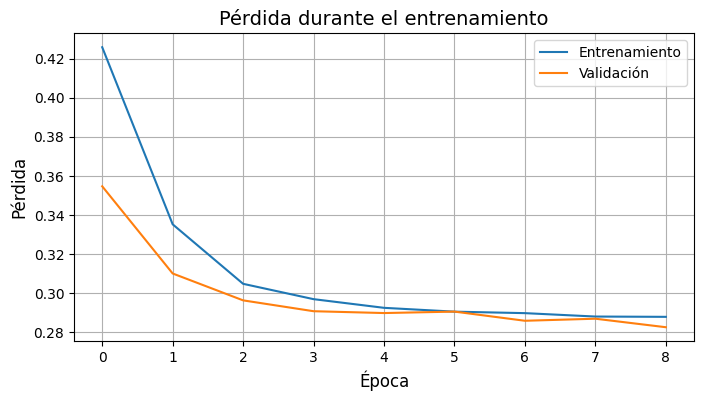

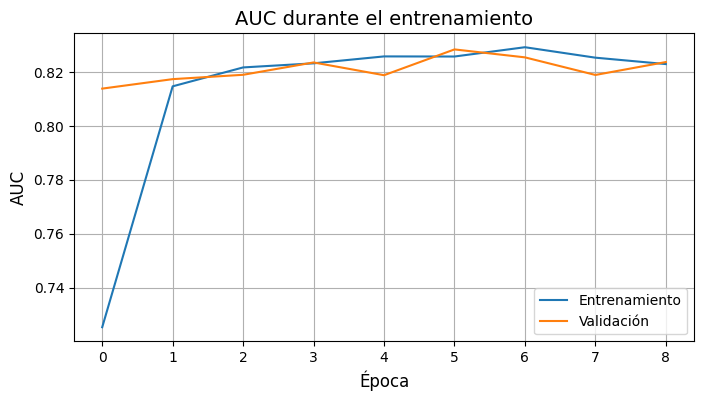

142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


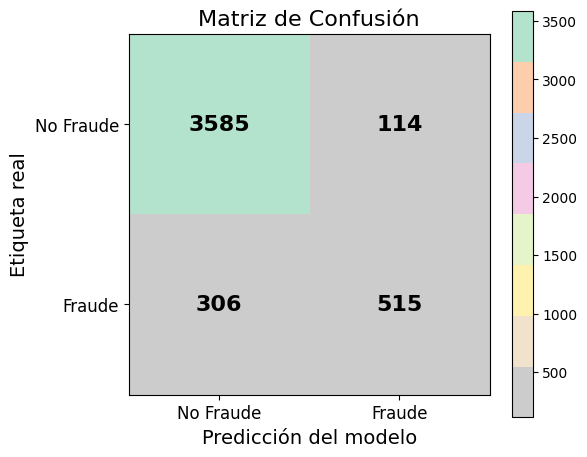

El modelo aprendió a detectar fraudes con un 62.73% de efectividad.


In [21]:
#importamos matplotlib para las graficas y numpy para arreglo de numeros
#Y sklearn para la matriz
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

#Hemos en lienzo con un tamaño de 8 de ancho y 4 de alto
plt.figure(figsize=(8,4))
#Dibujamos las lineas (Azul-error en entrenamiento y naranja error en validacion)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
#Colocamos las leyendas para la grafica
plt.title("Pérdida durante el entrenamiento", fontsize=14)
plt.xlabel("Época", fontsize=12)
plt.ylabel("Pérdida", fontsize=12)
plt.legend(["Entrenamiento","Validación"])
plt.grid(True)
#Dibuja la primera grafica
plt.show()

# #Dibujamos ahora la grafica para area bajo la curva
#Es mas importante por que muesra que tan bien distingue el modelo los fraudes
plt.figure(figsize=(8,4))
plt.plot(history.history["auc"])
plt.plot(history.history["val_auc"])
plt.title("AUC durante el entrenamiento", fontsize=14)
plt.xlabel("Época", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.legend(["Entrenamiento","Validación"])
plt.grid(True)
plt.show()

# Predecimos las probabilidades para los datos de prueba (0 y 1)
#Si es mayor a 0.5 es fraude si no es no fraude
y_pred = (model.predict(X_test) > 0.5).astype(int)
#Compara las etiquetas reales con las predicciones
cm = confusion_matrix(y_test, y_pred)
#Dibuja la matriz
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Pastel2_r')
plt.title("Matriz de Confusión", fontsize=16)
plt.xlabel("Predicción del modelo", fontsize=14)
plt.ylabel("Etiqueta real", fontsize=14)
#Colocamos los nombres para los ejes de cada matriz
clases = ["No Fraude", "Fraude"]

# Etiquetas en los ejes de la grafica
plt.xticks([0,1], clases, fontsize=12)
plt.yticks([0,1], clases, fontsize=12)

# Mostrar valores dentro de las celdas en grande y en negritas
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      #Añadimos una barra de color para representar que valor representa cada color
        plt.text(j, i, cm[i,j],
                 ha="center", va="center",
                 fontsize=16, color="black", fontweight="bold")

plt.colorbar()
plt.tight_layout()
plt.show()
porcentaje_aprendido = cm[1,1] / (cm[1,1] + cm[1,0])
#Imprimimos a efectividad calculada en porcentaje y lo imprime
print(f"El modelo aprendió a detectar fraudes con un {porcentaje_aprendido*100:.2f}% de efectividad.")
